In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors
import numpy as np
import os

%matplotlib inline
%load_ext autoreload
%autoreload 2

Paper

1. --> Statistics about window length (make prediction time and window variable --> predictions should be same time)
Increase the training data.
2. --> U, V, G (ask Cristiana) -- can we predict MJO using -- Replace the scalar timeseries with 
4 component timeseries and then use the mapping to predict MJO
3. --> Z500 do DA (with GP)

(17621,)
(9710,) (7621,)


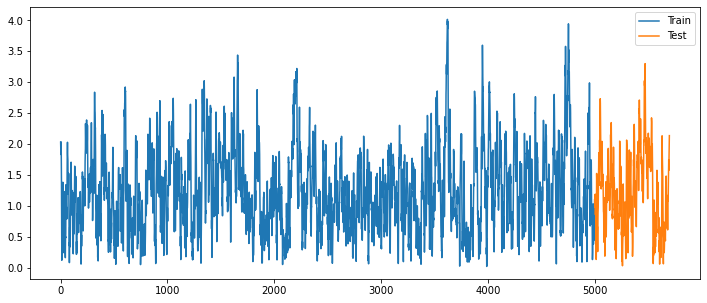

In [2]:
data = {}
entire_data = np.load('amplitude_data.npy')
print(entire_data.shape)
data['train'] = entire_data[:10000]
data['test'] = entire_data[10000:]
idx = np.where(data['train'] > 1e34)[0]
data['train'] = np.delete(data['train'], idx)
print(data['train'].shape, data['test'].shape)

N_train = 5000
N_forecast = 700
Ztrain = data['train'][:N_train] 
Ztest = data['train'][N_train:N_train+N_forecast]
# data['train'] = np.load(f'{datadir}/amplitude_data.npy').T
# data['test'] = np.load(f'{datadir}/Z500_Test_Snapshots.npy').T

plt.figure(figsize=(12, 5))
plt.plot(np.arange(N_train), Ztrain)
plt.plot(np.arange(N_train, N_train+N_forecast), Ztest)
plt.legend(['Train', 'Test'])

In [3]:
def rolling(a, window):
    shape = (a.size - window + 1, window)
    strides = (a.itemsize, a.itemsize)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [4]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
#         self.
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel())
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.LinearKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
#         covar_x = gpytorch.kernels.RBFKernel(x) + gpytorch.white_noise_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

/opt/homebrew/Caskroom/miniconda/base/envs/scientific/lib/python3.9/site-packages/linear_operator/utils/linear_cg.py:318: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.9963687658309937 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/scientific/lib/python3.9/site-packages/linear_operator/utils/linear_cg.py:318: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.2512047290802 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/opt/homebrew/Caskroom/mi

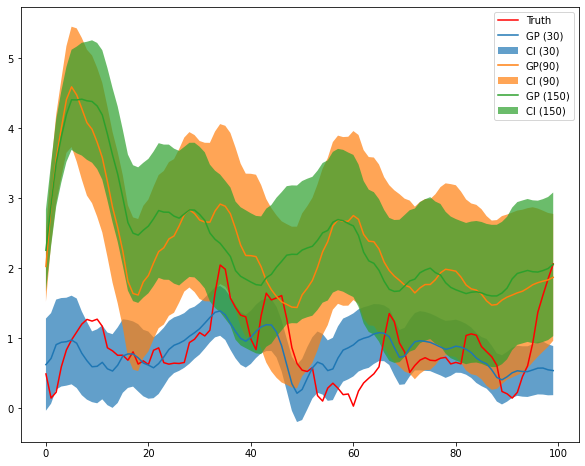

In [5]:
# rolling_widths = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
# plot_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown',
#               'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
rolling_widths = [30, 90, 150]

plot_colors = ['tab:blue', 'tab:orange', 'tab:green']

#plot_colors = ['tab:blue']

f, ax = plt.subplots(1, 1, figsize=(10, 8))
prediction_window  = 100
fixed_offset = 500
fixed_start = 200
dict_predictions ={}
dict_lower_confidence={}
dict_upper_confidence={}

ax.plot(np.arange(prediction_window),Ztest[fixed_start:fixed_start+prediction_window], 'r')
for rolling_width, col in zip(rolling_widths, plot_colors):
    Input_X = rolling(Ztrain[:-1], rolling_width)
    Output_Y = Ztrain[rolling_width:]
    x_np = torch.from_numpy(Input_X).float()
    y_np = torch.from_numpy(Output_Y).float()
    
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
# gpytorch.likelihoods.FixedNoiseGaussianLikelihood()
    model = ExactGPModel(x_np, y_np, likelihood)
    model = model.to(torch.float)
    
    smoke_test = ('CI' in os.environ)
    training_iter = 2 if smoke_test else 200

# Find optimal model hyperparameter
    model.train()
    likelihood.train()

# Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters
# "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    for i in range(training_iter):
       
        
    # Zero gradients from previous iteration
        optimizer.zero_grad()
    # Output from model
        output = model(x_np)
    # Calc loss and backprop gradients
        loss = -1*mll(output, y_np)
        loss.backward()
#         print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
#              i + 1, training_iter, loss.item(),
#              model.covar_module.base_kernel.lengthscale.item(),
#             model.likelihood.noise.item() ))
        optimizer.step()
        
        
    
    predictions = np.zeros(prediction_window)
    lower_confidence = np.zeros(prediction_window)
    upper_confidence = np.zeros(prediction_window)
    temp = np.copy(Ztest[:prediction_window+fixed_offset-1])
    temp = rolling(temp, rolling_width)
    model.eval()
    likelihood.eval()
    fixed_start = 200
    for i in range(prediction_window):
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            temp1 = temp[i+fixed_start - rolling_width,:]
            if(i != 0):
                temp1[-1] = observed_pred.mean.numpy()
            test_x = torch.from_numpy(temp1.reshape((1, rolling_width))).float()
            observed_pred = likelihood(model(test_x))
#         print(observed_pred)
            lower, upper = observed_pred.confidence_region()
            predictions[i] = observed_pred.mean.numpy()
            lower_confidence[i] = lower.detach().numpy()
            upper_confidence[i] = upper.detach().numpy()
    
    dict_predictions[rolling_width] = predictions
    dict_lower_confidence[rolling_width] = lower_confidence
    dict_upper_confidence[rolling_width] = upper_confidence
    ax.plot(np.arange(prediction_window), predictions, col)
    ax.fill_between(np.arange(prediction_window), lower_confidence, 
                     upper_confidence, alpha=0.7)
# y_np = torch.from_numpy(Output_Y)
# Input_X = rolling(Ztrain[:-1], rolling_width)
# print(Input_X.shape)
# Output_Y = Ztrain[rolling_width:]
# print(Output_Y.shape)
# x_np = torch.from_numpy(Input_X)
# y_np = torch.from_numpy(Output_Y)
# print(Input_X)
# #Increase rolling_width 
# #Increase number of training points

ax.legend(['Truth','GP (30)', 'CI (30)', 'GP(90)', 'CI (90)', 'GP (150)', 'CI (150)' ])
# ax.legend(['Truth','GP (60)', 'GP(100)', 'GP (150)' ])
# ax.legend(['Truth','GP (30)'])
# ax.set_ylim([-1.0, 1.0])

In [ ]:
for rolling_width, col in zip(rolling_widths, plot_colors):
    
  
    
    temp = np.copy(Ztest[:prediction_window+fixed_offset-1])
    temp = rolling(temp, rolling_width)
    
    print("rolling width :", rolling_width)
    for i in range(prediction_window):
        temp1 = temp[i+fixed_start - rolling_width,:]
        
        print(temp1)
        
    

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(10, 8))



ax.plot(np.arange(prediction_window),Ztest[:prediction_window]/Ztest[:prediction_window]-1, 'r')

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.set_ylim([-1, 1])

In [ ]:
rolling_widths = [30, 60, 100]

plot_colors = ['tab:blue', 'tab:orange', 'tab:green']

f, ax = plt.subplots(1, 1, figsize=(10, 8))
prediction_window  = 30
fixed_offset = 200


ax.plot(np.arange(prediction_window),Ztest[:prediction_window], 'r')
for rolling_width, col in zip(rolling_widths, plot_colors):
    Input_X = rolling(Ztrain[:-1], rolling_width)
    Output_Y = Ztrain[rolling_width:]
    x_np = torch.from_numpy(Input_X)
    y_np = torch.from_numpy(Output_Y)
    
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
# gpytorch.likelihoods.FixedNoiseGaussianLikelihood()
    model = ExactGPModel(x_np, y_np, likelihood)
    
    smoke_test = ('CI' in os.environ)
    training_iter = 2 if smoke_test else 200


# Find optimal model hyperparameter
    model.train()
    likelihood.train()

# Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
    # Zero gradients from previous iteration
        optimizer.zero_grad()
    # Output from model
        output = model(x_np)
    # Calc loss and backprop gradients
        loss = -mll(output, y_np)
        loss.backward()
#         print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
#             i + 1, training_iter, loss.item(),
#             model.covar_module.base_kernel.lengthscale.item(),
#             model.likelihood.noise.item() ))
        optimizer.step()
        
        
    
    predictions = np.zeros(prediction_window)
    lower_confidence = np.zeros(prediction_window)
    upper_confidence = np.zeros(prediction_window)
    temp = np.copy(Ztest[:prediction_window+fixed_offset-1])
    temp = rolling(temp, rolling_width)
    model.eval()
    likelihood.eval()
    fixed_start = 100
    for i in range(prediction_window):
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            temp1 = temp[i+fixed_start - rolling_width,:]
            if(i != 0):
                temp1[-1] = observed_pred.mean.numpy()
            test_x = torch.from_numpy(temp1.reshape((1, rolling_width)))
            observed_pred = likelihood(model(test_x))
#         print(observed_pred)
            lower, upper = observed_pred.confidence_region()
            predictions[i] = observed_pred.mean.numpy()
            lower_confidence[i] = lower.detach().numpy()
            upper_confidence[i] = upper.detach().numpy()
    
    ax.plot(np.arange(prediction_window), predictions, col)
# ax.plot(np.arange(200), observed_pred.mean.numpy(), 'b')
    ax.fill_between(np.arange(prediction_window), lower_confidence, 
                    upper_confidence, alpha=0.7)
# y_np = torch.from_numpy(Output_Y)
# Input_X = rolling(Ztrain[:-1], rolling_width)
# print(Input_X.shape)
# Output_Y = Ztrain[rolling_width:]
# print(Output_Y.shape)
# x_np = torch.from_numpy(Input_X)
# y_np = torch.from_numpy(Output_Y)
# print(Input_X)
# #Increase rolling_width 
# #Increase number of training points

ax.legend(['Truth','GP (30)', 'CI (30)', 'GP(60)', 'CI (60)', 'GP (100)', 'CI (100)' ])

In [ ]:


# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
# gpytorch.likelihoods.FixedNoiseGaussianLikelihood()
model = ExactGPModel(x_np, y_np, likelihood)

#

In [ ]:
# this is for running the notebook in our testing framework

smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 200


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(x_np)
    # Calc loss and backprop gradients
    loss = -mll(output, y_np)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()
    
    prediction_window  = 30
    predictions = np.zeros(prediction_window)
    lower_confidence = np.zeros(prediction_window)
    upper_confidence = np.zeros(prediction_window)
    temp = np.copy(Ztest[:prediction_window+rolling_width-1])
    temp = rolling(temp, rolling_width)
    model.eval()
    likelihood.eval()
    
    for i in range(prediction_window):
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            temp1 = temp[i,:]
            if(i != 0):
                temp1[-1] = observed_pred.mean.numpy()
            test_x = torch.from_numpy(temp1.reshape((1, rolling_width)))
            observed_pred = likelihood(model(test_x))
#         print(observed_pred)
            lower, upper = observed_pred.confidence_region()
            predictions[i] = observed_pred.mean.numpy()
            lower_confidence[i] = lower.detach().numpy()
            upper_confidence[i] = upper.detach().numpy()

In [ ]:
prediction_window  = 30
predictions = np.zeros(prediction_window)
lower_confidence = np.zeros(prediction_window)
upper_confidence = np.zeros(prediction_window)
fixed_length = 200
temp = np.copy(Ztest[:prediction_window+fixed_length-1])
temp = rolling(temp, rolling_width)
model.eval()
likelihood.eval()
for i in range(prediction_window):
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        temp1 = temp[i,:]
        if(i != 0):
            temp1[-1] = observed_pred.mean.numpy()
        test_x = torch.from_numpy(temp1.reshape((1, rolling_width)))
        observed_pred = likelihood(model(test_x))
#         print(observed_pred)
        lower, upper = observed_pred.confidence_region()
        predictions[i] = observed_pred.mean.numpy()
        lower_confidence[i] = lower.detach().numpy()
        upper_confidence[i] = upper.detach().numpy()

In [ ]:
lower, upper = observed_pred.confidence_region()

ax.plot(np.arange(prediction_window), predictions, 'rosybrown')
# ax.plot(np.arange(200), observed_pred.mean.numpy(), 'b')
ax.fill_between(np.arange(prediction_window), lower_confidence, upper_confidence, alpha=0.5)
ax.plot(np.arange(prediction_window),Ztest[rolling_width:rolling_width+prediction_window], 'r')
ax.legend(['GPyTorch (30)','Confidence Intervals (30)' ,'Truth'])
plt.ylim([0,4])

In [ ]:
print(observed_pred.mean.numpy())

In [ ]:
def plot_colortable(colors, sort_colors=True, emptycols=0):

    cell_width = 212
    cell_height = 22
    swatch_width = 48
    margin = 12

    # Sort colors by hue, saturation, value and name.
    if sort_colors is True:
        by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))),
                         name)
                        for name, color in colors.items())
        names = [name for hsv, name in by_hsv]
    else:
        names = list(colors)

    n = len(names)
    ncols = 4 - emptycols
    nrows = n // ncols + int(n % ncols > 0)

    width = cell_width * 4 + 2 * margin
    height = cell_height * nrows + 2 * margin
    dpi = 72

    fig, ax = plt.subplots(figsize=(width / dpi, height / dpi), dpi=dpi)
    fig.subplots_adjust(margin/width, margin/height,
                        (width-margin)/width, (height-margin)/height)
    ax.set_xlim(0, cell_width * 4)
    ax.set_ylim(cell_height * (nrows-0.5), -cell_height/2.)
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    ax.set_axis_off()

    for i, name in enumerate(names):
        row = i % nrows
        col = i // nrows
        y = row * cell_height

        swatch_start_x = cell_width * col
        text_pos_x = cell_width * col + swatch_width + 7

        ax.text(text_pos_x, y, name, fontsize=14,
                horizontalalignment='left',
                verticalalignment='center')

        ax.add_patch(
            Rectangle(xy=(swatch_start_x, y-9), width=swatch_width,
                      height=18, facecolor=colors[name], edgecolor='0.7')
        )

    return fig

In [ ]:
plot_colortable(mcolors.CSS4_COLORS)
plt.show()

In [ ]:
predictions = np.zeros(prediction_window)
rolling_width = 100  
temp = np.copy(Ztest[:prediction_window+200-1])
temp = rolling(temp, rolling_width)
print(temp[0])
print(temp[1])

In [ ]:
predictions = np.zeros(prediction_window)
rolling_width = 90  
temp = np.copy(Ztest[:prediction_window+200-1])
temp = rolling(temp, rolling_width)
print(temp[10])
print(temp[11])

In [ ]:
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 100)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)